In [13]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [14]:
import os

import clickhouse_connect
import matplotlib.pyplot as plt
import pandas as pd
from dotenv import load_dotenv


#load env file
load_dotenv("../notebooks/dev.env")
con = clickhouse_connect.get_client(
    interface="https",
    user=os.getenv("userOHSOME"),
    host=os.getenv("hostOHSOME"),
    password=os.getenv("pwOHSOME"),
    port=os.getenv("portOHSOME"))


<IPython.core.display.Javascript object>

# Filtering for hashtags
## monthly active users

,users,changesets,contributions
date,,,
2017-01-01,1930,59818,1281541
2017-02-01,2659,87093,1328880
2017-03-01,3747,102904,1479289
2017-04-01,2854,181338,2360697
2017-05-01,2568,123527,1955064


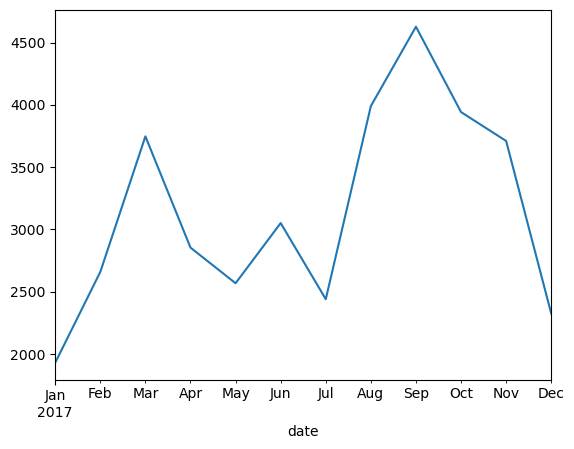

<IPython.core.display.Javascript object>

In [15]:
hashtag = "#missingmaps"

sql = f"""
    SELECT
    toYear(
        fromUnixTimestamp((changeset_timestamp/1000)::integer)
    ) as year,
    toMonth(
        fromUnixTimestamp((changeset_timestamp/1000)::integer)
    ) as month,
    count(DISTINCT user_id) as users,
    count(DISTINCT changeset_id) as changesets,
    count(DISTINCT contrib_id_text) as contributions
    FROM stats_2
    WHERE lower(hashtag) LIKE lower('{hashtag}')
    AND (FROM_UNIXTIME((changeset_timestamp/1000)::integer) BETWEEN  '2017-01-01' and '2017-12-31')
    GROUP BY year, month
"""

df = con.query_df(sql)
df["date"] = df.apply(
    lambda x: str(int(x.year)) + "-" + str(int(x.month)) + "-1", axis=1
)

df.date = pd.to_datetime(df.date)
df = df.set_index(pd.DatetimeIndex(df["date"])).drop(["year","month","date"],axis=1)

df = df.sort_index()

display(df.head(5))

df.users.plot()
plt.show()

## Aggregation by User filterted for hashtags

In [16]:
hashtag = "#missingmaps"

sql = f"""
    SELECT user_id,
    count(DISTINCT changeset_id) as changesets,
    count(DISTINCT contrib_id_text) as contributions
    FROM stats_2
    WHERE lower(hashtag) LIKE lower('{hashtag}')
    AND (FROM_UNIXTIME((changeset_timestamp/1000)::integer) BETWEEN  '2017-01-01' and '2017-12-31')
    GROUP BY user_id
    """

df = con.query_df(sql)

display(df.head(5))

,user_id,changesets,contributions
0,5769964,1,17
1,6933822,1,68
2,6573205,3,40
3,6334149,10,66
4,6565677,1,43


<IPython.core.display.Javascript object>

## Aggregation by hashtag

,hashtag_lower,users,changesets,contributions
date,,,,
2017-01-01,#missingmaps,1930,59818,1281541
2017-02-01,#missingmaps,2659,87093,1328880
2017-03-01,#missingmaps,3747,102904,1479289
2017-04-01,#missingmaps,2854,181338,2360697
2017-05-01,#missingmaps,2568,123527,1955064


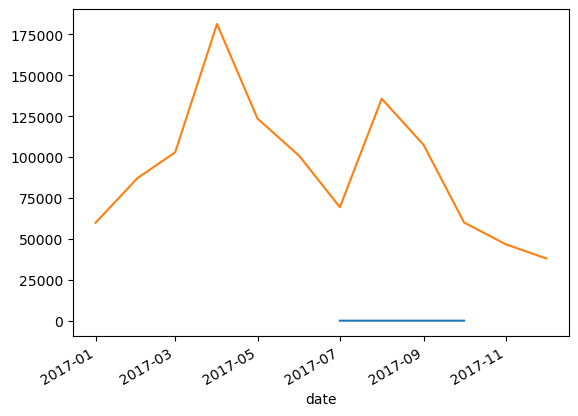

<IPython.core.display.Javascript object>

In [17]:
hashtags = ["#missingmaps", "#bloomberg", "visa",""]
sql = """

    SELECT lower(hashtag) as hashtag_lower,
    toYear(
        fromUnixTimestamp((changeset_timestamp/1000)::integer)
    ) as year,
    toMonth(
        fromUnixTimestamp((changeset_timestamp/1000)::integer)
    ) as month,
    count(DISTINCT user_id) as users,
    count(DISTINCT changeset_id) as changesets,
    count(DISTINCT contrib_id_text) as contributions
    FROM stats_2
    WHERE ({})
    AND (FROM_UNIXTIME((changeset_timestamp/1000)::integer) BETWEEN '2017-01-01' and '2017-12-31')
    GROUP BY hashtag_lower, year, month
    """.format(' or '.join(['lower(hashtag) like lower(\'{}\')'.format(hashtag.replace("*", "%")) for hashtag in hashtags]))

df = con.query_df(sql)

df["date"] = df.apply(
    lambda x: str(int(x.year)) + "-" + str(int(x.month)) + "-1", axis=1
)
df.date = pd.to_datetime(df.date)
df = df.set_index(pd.DatetimeIndex(df["date"])).drop(["year","month","date"],axis=1)

df = df.sort_index()
display(df.head(5))

df.groupby(["hashtag_lower"])["changesets"].plot()
plt.show()

# Differentiation contritubtions into creation, modifications and deletions


In [18]:
hashtag = "#missingmaps"
sql = f"""
        SELECT
        SUM(CASE WHEN (road_length > 0.0 and road_length_delta == road_length) THEN 1 ELSE 0 END) as creations,
        SUM(CASE WHEN (road_length > 0.0 and road_length_delta != road_length) THEN 1 ELSE 0 END) as modifications,
        SUM(CASE WHEN (road_length == 0.0 and road_length_delta < 0) THEN 1 ELSE 0 END) as deletions
        FROM stats_2
        WHERE lower(hashtag) ilike '{hashtag}'
    """
df = con.query_df(sql)

display(df.head(5))


,creations,modifications,deletions
0,2962155,3180320,350682


<IPython.core.display.Javascript object>

# combination of hastags
## OR combination

In [19]:
hashtags = ["#MissingMaps", "#bloomberg"]

sql = """
    SELECT count(*)
    FROM (
        SELECT *, ROW_NUMBER() OVER (PARTITION BY contrib_id_text ORDER BY osm_id DESC) AS rn
        FROM stats_2
        WHERE (
            ({})
            AND FROM_UNIXTIME((changeset_timestamp/1000)::integer) BETWEEN  '2017-01-01' and '2017-12-31'
            )
        )
    WHERE rn == 1
    """.format(' or '.join(['lower(hashtag) like lower(\'{}\')'.format(hashtag.replace("*", "%")) for hashtag in hashtags]))

%timeit df = con.query_df(sql)
display(df.head())


23.7 s ± 349 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


,creations,modifications,deletions
0,2962155,3180320,350682


<IPython.core.display.Javascript object>

## And combinations

In [20]:
hashtags = ["#MissingMaps", "#bloomberg"]
sql = """
    SELECT count(*),
    count(DISTINCT contrib_id_text)
    FROM (
        SELECT *, ROW_NUMBER() OVER (PARTITION BY contrib_id_text ORDER BY osm_id DESC) AS rn
        FROM stats_2
        WHERE (
            lower(hashtag) like lower('#missingmaps') or lower(hashtag) like lower('#bloomberg'))
            AND (FROM_UNIXTIME((changeset_timestamp/1000)::integer) BETWEEN  '2017-01-01' and '2017-12-31'
            )
        )
    WHERE rn == 2
    """

df = con.query_df(sql)
display(df.head(5))

,count(),uniqExact(contrib_id_text)
0,40838,40838


<IPython.core.display.Javascript object>

# Stats for individaul users

## top users for a hashtag

In [21]:
hashtag = "#MissingMaps"

sql = f"""
    SELECT user_id,
    count( DISTINCT contrib_id_text) as contributions
    FROM stats_2
    WHERE lower(hashtag) ILIKE lower('{hashtag}')
    AND (FROM_UNIXTIME((changeset_timestamp/1000)::integer) BETWEEN  '2017-01-01' and '2017-12-31')
    GROUP BY user_id
    ORDER BY contributions DESC
    """

df = con.query_df(sql)

display(df.head(5))

,user_id,contributions
0,2602222,354665
1,2896303,305158
2,4159996,273077
3,5099490,255870
4,5752603,251500


<IPython.core.display.Javascript object>

# Stats for countries
## Hashtags with most contributions in a country

In [22]:
sql = """
    SELECT lower(hashtag) as hashtag_lower,
    count( DISTINCT contrib_id_text) as contributions
    FROM stats_2
    WHERE has(country_iso_a3, 'UGA')
    AND (FROM_UNIXTIME((changeset_timestamp/1000)::integer) BETWEEN  '2017-01-01' and '2017-12-31')
    GROUP BY hashtag_lower
    ORDER BY contributions DESC
    """

df = con.query_df(sql)

display(df.head(5))

,hashtag_lower,contributions
0,#mapgive,455399
1,#youthmappers,398148
2,#missingmaps,343369
3,#smgl,223951
4,#hotosm-project-3254,181481


<IPython.core.display.Javascript object>